# 等离子体电子声波：Another test of Two-kappa Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
def fk(v):
    r_s = ( 1 + v**2/(kappa_s-3/2)/(2*T) )**(-kappa_s)
    r_f = ( 1 + v**2/(kappa_f-3/2)/(2*T) )**(-kappa_f)
    A_s = n_s/np.sqrt(2*np.pi*T*(kappa_s-3/2)) * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    A_f = n_f/np.sqrt(2*np.pi*T*(kappa_f-3/2)) * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    
    return A_s*r_s+A_f*r_f

def PDR_2KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    zeta_f = wc / k /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + (kappa_f/(kappa_f-1.5)) / k**2 / l_f**2 * ( 1 - 1/2/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f) )
    return [r.real,r.imag]

def PDR_1KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) )
    return [r.real,r.imag]

import quadpy

def dispersion_function(zeta,kappa):
    r = 0.0
    A_kappa = (kappa)**(-1.5) * sp.gamma(kappa+1) / sp.gamma(kappa-0.5)
    def integrand(xi):
        return  (1+xi**2/kappa)**(-kappa-1)
    if zeta.imag>0:
        r = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,np.inf)[0]
    elif zeta.imag==0:
        x = 0.1
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1 = (1/np.sqrt(np.pi)) * integrate.quad(integrand,s_n,s_p, weight='cauchy',wvar=zeta.real)[0]
        real2 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = real + 1j*imag
    elif zeta.imag<0:
        x = 1e-8
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1a = -1j * quadpy.quad(lambda xi_i: integrand(s_n+1j*xi_i)/(1j*xi_i-1j*zeta.imag-x),zeta.imag,0)[0]
        real1b =  1j * quadpy.quad(lambda xi_i: integrand(s_p+1j*xi_i)/(1j*xi_i-1j*zeta.imag+x),zeta.imag,0)[0]
        real2 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1a+real1b+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = (1/np.sqrt(np.pi)) * real + 1j*imag
    return r * A_kappa

def PrintParas():
    paras_table = PrettyTable(['T='+str(T),'n','kappa','wp','theta','lambda_D'])
    paras_table.add_row(['s',n_s,kappa_s,round(wp_s,4),round(v_s,4),round(l_s,4)])
    paras_table.add_row(['f',n_f,kappa_f,round(wp_f,4),round(v_f,4),round(l_f,4)])
    print(paras_table)
    
def SetParas():
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    v_s = np.sqrt((2-3/kappa_s)*T/m)
    v_f = np.sqrt((2-3/kappa_f)*T/m)
    return n_f,l_s,l_f,wp_s,wp_f,v_s,v_f

### PDR中的KW分支和LW分支

In [6]:
# 等离子体基本参数
n = 1
q = 1
m = 1
T = 500

n_s = 0.8
kappa_s = 1.6
kappa_f = 100

n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
PrintParas()

+-------+---------------------+-------+--------+---------+----------+
| T=500 |          n          | kappa |   wp   |  theta  | lambda_D |
+-------+---------------------+-------+--------+---------+----------+
|   s   |         0.8         |  1.6  | 0.8944 |  7.9057 |   25.0   |
|   f   | 0.19999999999999996 |  100  | 0.4472 | 31.3847 |   50.0   |
+-------+---------------------+-------+--------+---------+----------+


In [386]:
wrkg = 0.5
wikg = -0.001
wrlg = 1.07
wilg = -0.24

In [387]:
k_list = np.linspace(0.1,1.0,num=20)
# 搜索解方程初值
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[wrkg,wikg])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[wrlg,wilg])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)
wrkg = s0.x[0] 
wikg = s0.x[1]
wrlg = s1.x[0]
wilg = s1.x[1]

k =  0.1
True [ 2.68783156 -4.62878069]
True [ 1.1483725  -0.70232766]


In [390]:
wr_kw_guess = 1.14
wi_kw_guess = -0.70
wr_lw_guess = 2.68
wi_lw_guess = -4.62

wr_lw_list = []
wi_lw_list = []
wr_kw_list = []
wi_kw_list = []

for k_each in tqdm(k_list,position=0,leave=True):
    s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
    if s_kw.success==True:
        wr_kw = s_kw.x[0]
        wi_kw = s_kw.x[1]
        wr_kw_guess = wr_kw
        wi_kw_guess = wi_kw
        wr_kw_list.append(wr_kw)
        wi_kw_list.append(wi_kw)

    s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess])
    if s_lw.success==True:
        wr_lw = s_lw.x[0]
        wi_lw = s_lw.x[1]
        wr_lw_guess = wr_lw
        wi_lw_guess = wi_lw
        wr_lw_list.append(wr_lw)
        wi_lw_list.append(wi_lw)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:51<00:00,  4.29s/it]


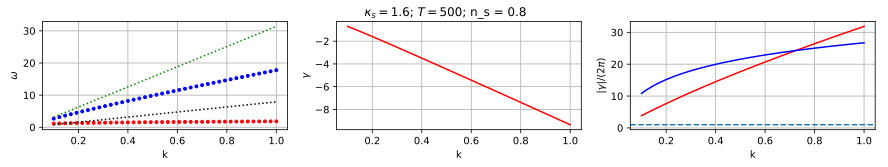

In [393]:
fig = plt.figure(figsize=(15,2))

ax1 = plt.subplot(131)
ax1.plot(k_list,wr_kw_list,'.',color='red')
ax1.plot(k_list,wr_lw_list,'.',color='blue')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\omega$')
ax1.plot(k_list,k_list*v_s,color='black',ls=':')
ax1.plot(k_list,k_list*v_f,color='green',ls=':')
ax1.grid()

ax2 = plt.subplot(132)
ax2.plot(k_list,wi_kw_list,color='red')
# ax2.plot(k_list,wi_lw_list,color='blue')
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()

b_kw = abs(np.array(wi_kw_list)/(np.array(wr_kw_list)/2/np.pi))
b_lw = abs(np.array(wi_lw_list)/(np.array(wr_lw_list)/2/np.pi))
ax3 = plt.subplot(133)
ax3.plot(k_list,b_kw,color='red')
ax3.plot(k_list,b_lw,color='blue')
ax3.axhline(1,linestyle='--')
ax3.set_xlabel('k')
ax3.set_ylabel(r'$|\gamma|/(2\pi)$')
ax3.grid()
plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $T = $"+str(T)+"; n_s = "+str(n_s))
plt.show()

### KW波色散关系随T变化规律

In [188]:
k_list = np.linspace(0.1,1.0,num=20)
T_list = np.linspace(1,10,num=10)

In [203]:
n_s=0.7
T = T_list[0]
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.099,-0.12])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.118,-0.025])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)

k =  0.1
True [ 0.08940658 -0.07780248]
True [ 1.00726222 -0.00119581]


In [204]:
wr_kw_guess = 0.089
wi_kw_guess = -0.077
wr_lw_guess = 1.007
wi_lw_guess = -0.0011

wr_lw_mat = []
wi_lw_mat = []
wr_kw_mat = []
wi_kw_mat = []
b_mat = []

for T_each in tqdm(T_list,position=0,leave=True):
    T = T_each
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )

    v_s = np.sqrt((2-3/kappa_s)*T/m)
    v_f = np.sqrt((2-3/kappa_f)*T/m)

    wr_lw_list = []
    wi_lw_list = []
    wr_kw_list = []
    wi_kw_list = []
    
    for k_each in k_list:
        s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
        if s_kw.success==True:
            wr_kw = round(s_kw.x[0],6)
            wi_kw = round(s_kw.x[1],6)
            wr_kw_guess = wr_kw
            wi_kw_guess = wi_kw
            if wr_kw not in wr_kw_list:
                wr_kw_list.append(wr_kw)
                wi_kw_list.append(wi_kw)

        s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess])
        if s_lw.success==True:
            wr_lw = round(s_lw.x[0],6)
            wi_lw = round(s_lw.x[1],6)
            wr_lw_guess = wr_lw
            wi_lw_guess = wi_lw
            if wr_lw not in wr_lw_list:
                wr_lw_list.append(wr_lw)
                wi_lw_list.append(wi_lw)
        b_list = abs(np.array(wi_kw_list)/(np.array(wr_kw_list)/2/np.pi))
        
    wr_kw_guess = wr_kw_list[0]
    wi_kw_guess = wi_kw_list[0]
    wr_lw_guess = wr_lw_list[0]
    wi_lw_guess = wi_lw_list[0]
    
    wr_kw_mat.append(wr_kw_list)
    wi_kw_mat.append(wi_kw_list)
    wr_lw_mat.append(wr_lw_list)
    wi_lw_mat.append(wi_lw_list)
    b_mat.append(b_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [14:36<00:00, 87.65s/it]


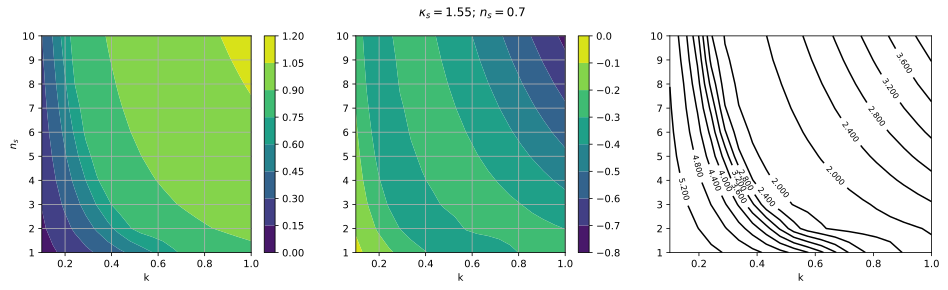

In [205]:
k_grid,T_grid=np.meshgrid(k_list,T_list)
fig = plt.figure(figsize=(16,4))

ax1 = plt.subplot(131)
cm1 = ax1.contourf(k_grid,T_grid,wr_kw_mat)
ax1.set_xlabel('k')
ax1.set_ylabel(r'$T$')
ax1.grid()
fig.colorbar(cm1)

ax2 = plt.subplot(132)
cm2 = ax2.contourf(k_grid,T_grid,wi_kw_mat)
ax2.set_xlabel('k')
ax2.grid()
fig.colorbar(cm2)

ax3 = plt.subplot(133)
# ax3.contourf(k_grid,T_grid,b_mat)
c = ax3.contour(k_grid,T_grid,b_mat,levels=10,colors='black')
ax3.clabel(c,inline=True,fontsize=8)
ax3.set_xlabel('k')
# ax3.grid()

plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $n_s = $"+str(n_s))
plt.show()

### KW波色散关系随$n_s$变化规律

In [409]:
k_list = np.linspace(0.1,1.0,num=20)
n_s_list = np.linspace(0.1,0.7,num=7)

In [410]:
kappa_s = 1.51
n_s=n_s_list[0]
T = 1
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.053,-0.063])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.06,-0.0001])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)

k =  0.1
True [ 0.03671858 -0.04185151]
True [ 1.01431382e+00 -2.64186174e-04]


In [411]:
wr_kw_guess = 0.036
wi_kw_guess = -0.041
wr_lw_guess = 1.014
wi_lw_guess = -2.6e-4

wr_lw_mat = []
wi_lw_mat = []
wr_kw_mat = []
wi_kw_mat = []
b_mat = []

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )

    v_s = np.sqrt((2-3/kappa_s)*T/m)
    v_f = np.sqrt((2-3/kappa_f)*T/m)

    wr_lw_list = []
    wi_lw_list = []
    wr_kw_list = []
    wi_kw_list = []
    
    for k_each in k_list:
        s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
        if s_kw.success==True:
            wr_kw = round(s_kw.x[0],6)
            wi_kw = round(s_kw.x[1],6)
            wr_kw_guess = wr_kw
            wi_kw_guess = wi_kw
            if wr_kw not in wr_kw_list:
                wr_kw_list.append(wr_kw)
                wi_kw_list.append(wi_kw)

        s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess])
        if s_lw.success==True:
            wr_lw = round(s_lw.x[0],6)
            wi_lw = round(s_lw.x[1],6)
            wr_lw_guess = wr_lw
            wi_lw_guess = wi_lw
            if wr_lw not in wr_lw_list:
                wr_lw_list.append(wr_lw)
                wi_lw_list.append(wi_lw)
        b_list = abs(np.array(wi_kw_list)/(np.array(wr_kw_list)/2/np.pi))
        
    wr_kw_guess = wr_kw_list[0]
    wi_kw_guess = wi_kw_list[0]
    wr_lw_guess = wr_lw_list[0]
    wi_lw_guess = wi_lw_list[0]
    
    wr_kw_mat.append(wr_kw_list)
    wi_kw_mat.append(wi_kw_list)
    wr_lw_mat.append(wr_lw_list)
    wi_lw_mat.append(wi_lw_list)
    b_mat.append(b_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [08:57<00:00, 76.76s/it]


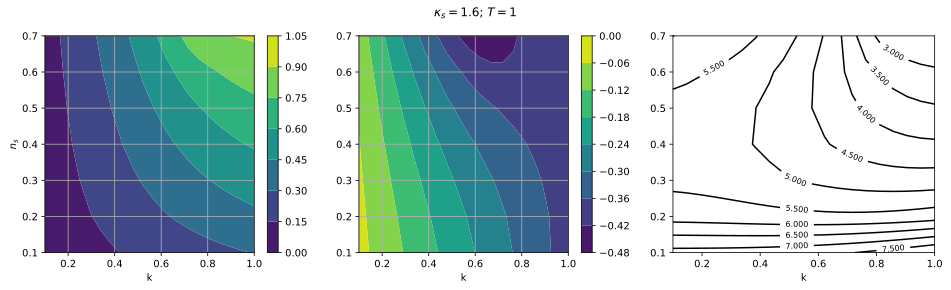

In [414]:
k_grid,n_s_grid=np.meshgrid(k_list,n_s_list)
fig = plt.figure(figsize=(16,4))

ax1 = plt.subplot(131)
cm1 = ax1.contourf(k_grid,n_s_grid,wr_kw_mat)
ax1.set_xlabel('k')
ax1.set_ylabel('$n_s$')
ax1.grid()
fig.colorbar(cm1)

ax2 = plt.subplot(132)
cm2 = ax2.contourf(k_grid,n_s_grid,wi_kw_mat)
ax2.set_xlabel('k')
ax2.grid()
fig.colorbar(cm2)

ax3 = plt.subplot(133)
c = ax3.contour(k_grid,n_s_grid,b_mat,levels=10,colors='black')
ax3.clabel(c,inline=True,fontsize=8)
ax3.set_xlabel('k')
# ax3.grid()

plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $T = $"+str(T))
plt.show()

### KW波存在条件：$\gamma < \omega/(2\pi)$
令$b = \gamma/\frac{\omega}{2\pi}$

#### $b_{min}(n_s,T)$图

In [334]:
k_list = np.linspace(0.1,1.0,num=20)
n_s_list = np.linspace(0.2,0.7,num=8)
T_list = np.linspace(5,50,num=10)

In [314]:
n_s=n_s_list[0]
T = T_list[0]
kappa_s = 1.6
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.1,-0.1])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.07,-0.002])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)

k =  0.1
True [ 0.11122894 -0.10183173]
True [ 1.07203841 -0.00286777]


In [336]:
b_min_mat = []
kappa_s = 1.6
wr_kw_guess = 0.11
wi_kw_guess = -0.101
wr_k0 = 0.0
wi_k0 = 0.0
wr_T0 = 0.0
wi_T0 = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    n_f = n-n_s
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    b_min_list = []
    for T_each in T_list:
        T = T_each
        l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
        l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
        v_s = np.sqrt((2-3/kappa_s)*T/m)
        v_f = np.sqrt((2-3/kappa_f)*T/m)
        
        b_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                b_list=np.append(b_list,abs(s.x[1]/(s.x[0]/2/np.pi)))
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if T_each == T_list[0]:
                    wr_T0 = wr_k0
                    wi_T0 = wi_k0
        b_min_list.append(np.amin(b_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    b_min_mat.append(b_min_list)
    wr_kw_guess = wr_T0
    wi_kw_guess = wi_T0

100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [55:20<00:00, 415.05s/it]


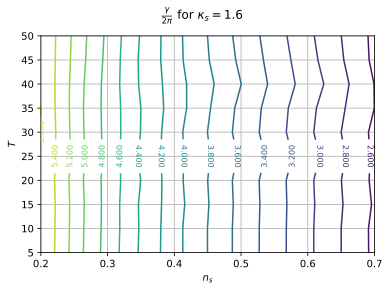

In [337]:
T_grid,n_s_grid=np.meshgrid(T_list,n_s_list)
c = plt.contour(n_s_grid,T_grid,b_min_mat,levels=15)
plt.clabel(c,inline=True,fontsize=8)
plt.suptitle(r'$\frac{\gamma}{2\pi}$' + r' for $\kappa_s=$'+str(kappa_s))
plt.xlabel('$n_s$')
plt.ylabel('$T$')
plt.grid()
plt.show()

#### $b_{min}(n_s,\kappa_s)$图

In [51]:
k_list = np.linspace(0.1,1.0,num=20)
n_s_list = np.linspace(0.1,0.75,num=15)
kappa_s_list = np.linspace(1.502,1.52,num=10)

In [52]:
n_s=n_s_list[0]
T = 5
kappa_s = kappa_s_list[0]
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.033,-0.008])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.04,-1e-5])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)

k =  0.1
True [ 0.07298927 -0.01875152]
True [ 1.07574721e+00 -6.68292015e-04]


In [53]:
b_min_mat = []
wr_kw_guess = 0.072
wi_kw_guess = -0.018
wr_k0 = 0.0
wi_k0 = 0.0
wr_kappa0 = 0.0
wi_kappa0 = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    b_min_list = []
    for kappa_s_each in kappa_s_list:
        kappa_s = kappa_s_each
        v_s = np.sqrt((2-3/kappa_s)*T/m)
        v_f = np.sqrt((2-3/kappa_f)*T/m)
        b_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                b_list=np.append(b_list,abs(s.x[1]/(s.x[0]/2/np.pi)))
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if kappa_s_each == kappa_s_list[0]:
                    wr_kappa0 = wr_k0
                    wi_kappa0 = wi_k0
        b_min_list.append(np.amin(b_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    b_min_mat.append(b_min_list)
    wr_kw_guess = wr_kappa0
    wi_kw_guess = wi_kappa0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [1:43:14<00:00, 412.97s/it]


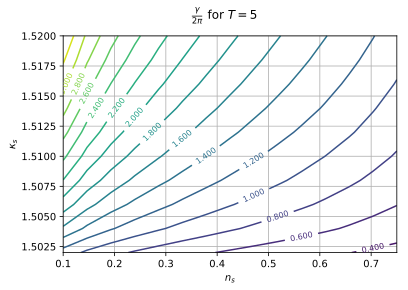

In [54]:
kappa_s_grid,n_s_grid=np.meshgrid(kappa_s_list,n_s_list)
c = plt.contour(n_s_grid,kappa_s_grid,b_min_mat,levels=15)
plt.clabel(c,inline=True,fontsize=8)
plt.suptitle(r'$\frac{\gamma}{2\pi}$' + r' for $T=$'+str(T))
plt.xlabel('$n_s$')
plt.ylabel('$\kappa_s$')
plt.grid()
plt.show()